In [10]:
%config Completer.use_jedi = False

# CASE STUDY - convolutional neural networks

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

Synopsis
----------

You were hired at AAVAIL to be a member of a data science team that works closely together.  Some of your first projects
are meant to help marketing with customer retention and to investigate market specific trends. There are also some
projects relating to user comments that are getting off the ground.  However, you will also be working alongside
the deep-learning specialists that maintain the core product at AAVAIL---its audio and visual manipulation models.

Because the team meets regularly all new data science hires are expected to go through a series deep-learning tutorials
to ensure that they can contribute to conversations about the core product.   The first in this series is the following
tutorial on CNNs.  You will be guided through the following parts.

  1. Environment setup
  2. Model scaffolding using Keras
  3. Logging and Model serialization
  4. Model iteration

## Fashion MNIST

>One project that the data science team at AAVAIL has been tasked with is ensuring that the video feeds are in fact news video feeds.  There are people that are performing quality assurance on these feeds, but eventually the data science team will need to build a service that samples a number of frames from a video, then identifies objects in the images, flagging for review any feeds that may be different.

A solid benchmark dataset for this task is the Fashion MNIST dataset.  

* training set - 60,000 images
* test set - 10,000 images
* images are 28 pixels x 28 pixels
* classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## PART 1 - environment setup

In [3]:
## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3139419398785936771
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11628588486997542854
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

### QUESTION 1

Visualize a sample of the images to QA the data set (You should scroll through several pages of images) and print a summary of the data.  Also create a base model to compare your neural network to.

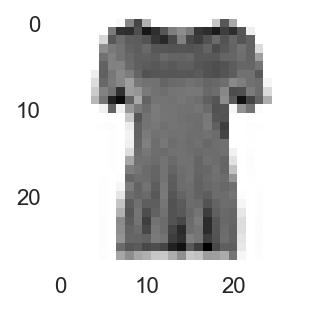

In [5]:
# Show an image

fig = plt.figure(figsize=(2,2), dpi=160, facecolor='w')
ax = fig.add_subplot(111)

ax.imshow(train_images[10])
ax.grid(False)


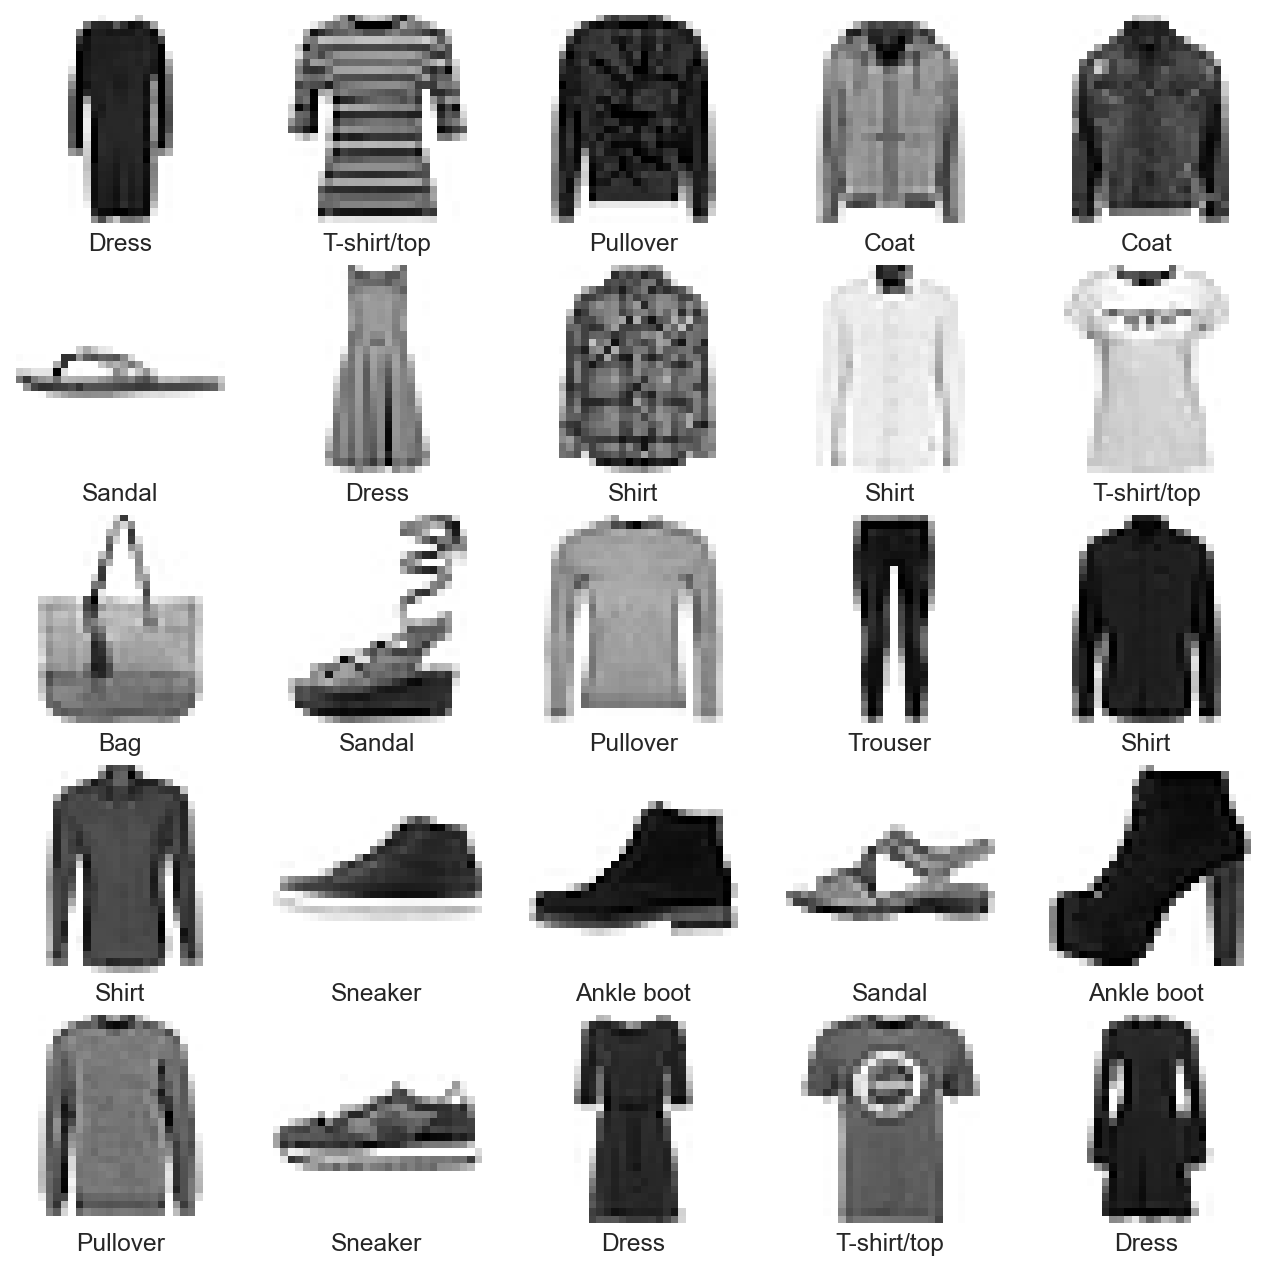

In [6]:
# Show class examples

fig = plt.figure(figsize=(10,10), dpi=160, facecolor='w')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])
    

In [8]:
## YOUR CODE HERE (Summarize the data)
## print basic info
print(f'X_train: {X_train.shape}')
class_info = list(sorted(Counter(y_train).items()))
print(f'num classes: {len(class_info)}, classes {[i[0] for i in class_info]}')
print(f'class samples: {[i[1] for i in class_info]}')
print(f'class balance: {[round(i[1]/X_train.shape[0],2) for i in class_info]}')
print(f'class names: {class_names}')


X_train: (60000, 28, 28)
num classes: 10, classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class samples: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
class balance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### QUESTION 2

Build a base model.  Construct a pipeline that uses PCA into a classic machine learning model.

In [14]:
## YOUR CODE HERE (base model)

X_train_flat = np.array([i.flatten() for i in train_images])
X_test_flat = np.array([i.flatten() for i in test_images])

def run_pipeline():
    
    pipe = Pipeline([('pca', PCA()),
                     ('svm', SVC(class_weight='balanced'))])

    param_grid = {
        'pca__n_components': [5, 10, 25],
        'svm__C': [0.001, 0.1, 10.0],
        'svm__gamma': [0.1, 0.01]
    }

    ## grid search
    saved_model = 'pca-svm.joblib'
    if not os.path.exists(saved_model):
        time_start = time.time()
        
        grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1, verbose=1)
        grid.fit(X_train_flat, y_train)
        
        joblib.dump(grid, saved_model)
        print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
    else:
        print(f'loading {saved_model} from file')
        grid = joblib.load(saved_model)
    
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(grid.best_params_)    
    

run_pipeline()

KeyboardInterrupt: 

## PART 2 -  model scaffolding using Keras

Create a function that returns a model using ``keras.models.Sequential()`` and ensure that you pass ``activation_function`` as an argument.  Instaintiate a version of the model and print the summary.  This function is just meant to return a simple multilayer perceptron network.  At a minimum the function code should contain:

```python
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
```

### QUESTION 3

Build a simple MLP

In [15]:
## YOUR CODE HERE
def simple_mlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model


### QUESTION 4

Create another version of your neural network.  This time you should build a proper CNN.  Remember that one pattern to consider starting from is alternating ``Con2D`` and ``MaxPooling2D`` layers.  This is often followed by a couple of ``Dense`` layers.  Recall that the the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The output of the last ``Dense`` layer should correspond to the number of classes and generally uses a 'softmax' activation.  Use `model.summary()` to ensure a cohesive architecture.

In [ ]:
## YOUR CODE HERE

def simple_cnn_model(af='relu'):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=af, input_shape=(28, 28)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=af))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=af))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=af))
    model.add(layers.Dense(10))
    return model

## PART 3 - logging and Model serialization

You can use a trained model without having to retrain it.  Your can also continue training a model to pick-up training where you left off.  The `tf.keras.callbacks.ModelCheckpoint` callback allows to continually save the model both during and at the end of training.  For long running models this is ideal in case the training is interrupted.  Otherwise you can 
used `model.save()` and `model.load()`.  In this part you will create a function that accomplished a few things at once.  Here is some pseudocode that you could work from.
```python
def train_network(model_name,model,loss_fn, optimizer='adam'):

    if not os.path.exists(saved model):
        model.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['accuracy'])
        model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test))
        
        create_log_file()
        model.save(saved_model)
    else:
        print("... loading saved model")
        model = keras.models.load_model(saved_model)
        
    return(model)    
```    
The two things you are trying to accomplish with this function are:

1. save your models so that each iteration only needs to be run once
2. save the specifics of your model in a log file 

  * optimizer 
  * loss_fn 
  * test_loss
  * test_accuracy
  * any notes

In [10]:
## YOUR CODE HERE
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True)


def train_network(model_name,model,loss_fn, optimizer='adam'):
        models_dir = 'models'
        model_file = models_dir + '/' + model_name
    
    if not os.path.exists(model_file):
        model.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['accuracy'])
        history = model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test),
                  callbacks=[tensorboard_callback, cp_callback])

        model.save(model_file)
    else:
        print("... loading saved model")
        model = keras.models.load_model(model_file)

    return(model)    

## PART 4 - model iteration

In [11]:
## YOUR CODE HERE (build and train a MLP)


In [13]:
## YOUR CODE HERE (build and train a CNN)

## add the channel dimensions to your data
X_train_1 = np.expand_dims(X_train, -1)
X_test_1 = np.expand_dims(X_test, -1)
